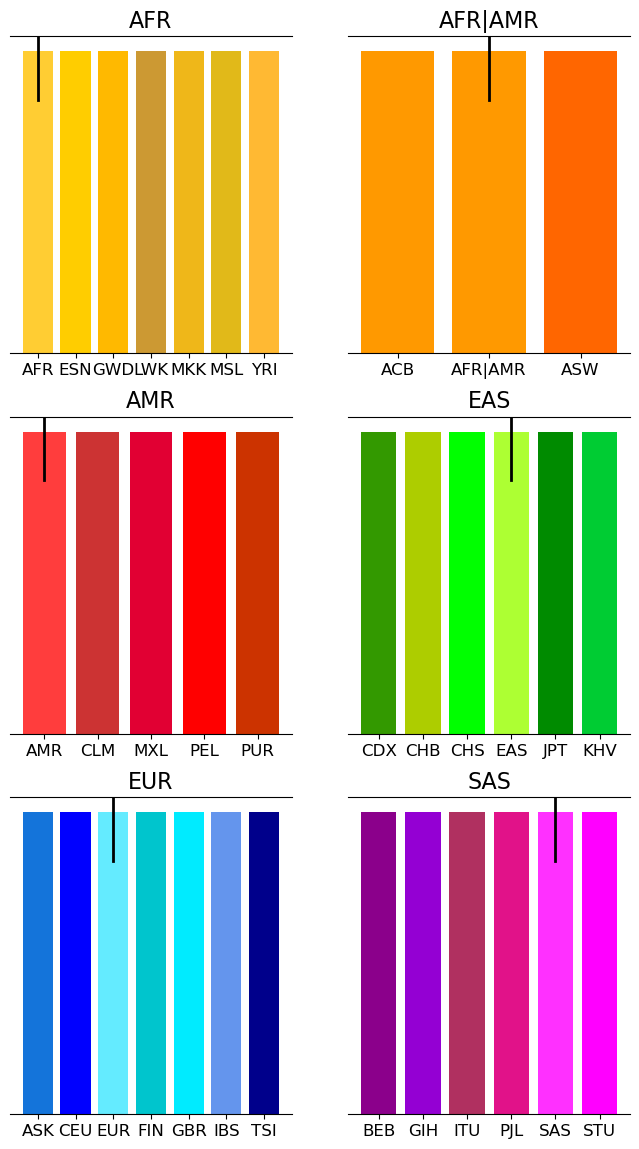

In [5]:
import pandas as pd
import pathlib as pl
import collections as col
import matplotlib.colors as colors
import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.rcParams['pdf.fonttype'] = 42


def rgb_to_cmyk(*args):
    
    def _int_to_float(i):
        return round(int(i)/255,3)
    
    def _float(f):
        return round(float(f),3)
    
    if len(args) == 1:
        rgb_object = args[0]
        if isinstance(rgb_object, str):
            num_parts = rgb_object.split(",")
            red, green, blue = num_parts[:3]
        elif isinstance(rgb_object, tuple) or isinstance(rgb_object, list):
            if len(rgb_object) < 3 or len(rgb_object) > 4:
                raise ValueError("Iterable error")
            red, green, blue = rgb_object[:3]
        else:
            raise ValueError("Other error")
    elif 2 < len(args) < 5:
        red, green, blue = args[:3]
    else:
        raise
        
    try:
        red = _int_to_float(red)
        green = _int_to_float(green)
        blue = _int_to_float(blue)
    except ValueError:
        red = _float(red)
        green = _float(green)
        blue = _float(blue)
    
    black = min(1-red, 1-green, 1-blue)
    if black == 1:
        cyan, magenta, yellow = 0, 0, 0
    else:
        cyan = (1-red-black)/(1-black)
        magenta = (1-green-black)/(1-black)
        yellow = (1-blue-black)/(1-black)
        
    cyan = int(round(cyan * 100, 0))
    magenta = int(round(magenta * 100, 0))
    yellow = int(round(yellow * 100, 0))
    black = int(round(black * 100, 0))
    
    return cyan, magenta, yellow, black


def normalize_continental_group(group):
    
    if "AFR" in group and "AMR" in group:
        return "AFR|AMR"
    return group.strip()


def rgb_to_hex(row):
    
    r,g,b = row.rgb_red_rel, row.rgb_green_rel, row.rgb_blue_rel
    hex_value = colors.to_hex((r,g,b))
    return f"{hex_value}".upper()


def conv_rgb_to_cmyk(row, stringlify=True):
    
    r,g,b = row.rgb_red_abs, row.rgb_green_abs, row.rgb_blue_abs
    c,m,y,k = rgb_to_cmyk(r,g,b)
    if stringlify:
        cmyk = f"{c},{m},{y},{k}"
    else:
        cmyk = c,m,y,k
    return cmyk


df = pd.read_csv(
    pl.Path(
        "/home/ebertp/work/code/cubi/project-run-hgsvc-hybrid-assemblies/annotations/external",
        "1KGP_Color_Scheme_v2.tsv")
    , sep="\t",
)
df.rename({"Population": "population"}, axis=1, inplace=True)
df["continental_group"] = df["Continental Group"].apply(normalize_continental_group)
df.loc[pd.isnull(df["population"]), "population"] = df.loc[pd.isnull(df["population"]), "continental_group"]
df["rgb_red_abs"] = df["Phase 3 Red"].astype(int)
df["rgb_green_abs"] = df["Phase 3 Green"].astype(int)
df["rgb_blue_abs"] = df["Phase 3 Blue"].astype(int)

df.drop(
    [
        "Continental Group",
        "Phase 3 Red",
        "Phase 3 Green",
        "Phase 3 Blue",
        "P3 Hex Value"
    ], axis=1, inplace=True
)

#################################################
### Add new population for HG002/NA24385 --- ASK
select_eur_pops = df["continental_group"] == "EUR"
deselect_group = df["population"] != "EUR"
selector = select_eur_pops & deselect_group
eur_pops = selector.sum()
ask_red = int((df.loc[selector, "rgb_red_abs"].sum() / eur_pops).round(0))
ask_green = int((df.loc[selector, "rgb_green_abs"].sum() / eur_pops).round(0))
ask_blue = int((df.loc[selector, "rgb_blue_abs"].sum() / eur_pops).round(0))

ask = pd.DataFrame([["ASK", "EUR", ask_red, ask_green, ask_blue]], columns=df.columns)
df = pd.concat([df, ask], axis=0, ignore_index=True)

### Add new population for NA21487 / MKK
select_afr_pops = df["continental_group"] == "AFR"
deselect_group = df["population"] != "AFR"
selector = select_afr_pops & deselect_group
afr_pops = selector.sum()
mkk_red = int((df.loc[selector, "rgb_red_abs"].sum() / afr_pops).round(0))
mkk_green = int((df.loc[selector, "rgb_green_abs"].sum() / afr_pops).round(0))
mkk_blue = int((df.loc[selector, "rgb_blue_abs"].sum() / afr_pops).round(0))

mkk = pd.DataFrame([["MKK", "AFR", mkk_red, mkk_green, mkk_blue]], columns=df.columns)
df = pd.concat([df, mkk], axis=0, ignore_index=True)
#################################################

df["rgb_abs"] = (
    df["rgb_red_abs"].astype(str) + ","
    + df["rgb_green_abs"].astype(str) + ","
    + df["rgb_blue_abs"].astype(str)
)

df["rgb_red_rel"] = (df["rgb_red_abs"]/255).round(3)
df["rgb_green_rel"] = (df["rgb_green_abs"]/255).round(3)
df["rgb_blue_rel"] = (df["rgb_blue_abs"]/255).round(3)

df["rgb_rel"] = (
    df["rgb_red_rel"].astype(str) + ","
    + df["rgb_green_rel"].astype(str) + ","
    + df["rgb_blue_rel"].astype(str)
)

df["hex_value"] = df.apply(rgb_to_hex, axis=1)

df["cmyk"] = df.apply(conv_rgb_to_cmyk, axis=1)
cmyk = df.apply(conv_rgb_to_cmyk, axis=1, stringlify=False)
df_cmyk = pd.DataFrame.from_records(
    cmyk,
    columns=["cmyk_cyan", "cmyk_magenta", "cyan_yellow", "cyan_black"]
)

df = pd.concat([df, df_cmyk], axis=1, ignore_index=False)

df.sort_values(["continental_group", "population"], axis=0, inplace=True)
df.reset_index(drop=True, inplace=True)

fig, axes = plt.subplots(figsize=(8,14), nrows=3, ncols=2, sharey=True, sharex=False)

col = 0
row = 0
for cgroup, pops in df.groupby("continental_group"):
    ax = axes[row, col]
    pos = range(1, len(pops)+1)
    heights = [1] * len(pos)
    ax.bar(
        pos,
        heights,
        color=pops["hex_value"]
    )
    ax.set_xticks(pos)
    ax.set_xticklabels(pops["population"].values, fontsize=12)
    ax.set_title(cgroup, fontsize=16)
    ax.set_yticks([])
    ax.spines.left.set_visible(False)
    ax.spines.right.set_visible(False)
    
    for idx, label in enumerate(pops["population"], start=1):
        if label == cgroup:
            ax.axvline(idx, 0.8, 1.0, lw=2, color="black")
    
    col += 1
    if col > 1:
        row += 1
        col = 0


dest_pdf = pl.Path(
    "/home/ebertp/work/code/cubi/project-run-hgsvc-hybrid-assemblies/annotations/projectmng",
    "hgsvc3_pop_colors.pdf"
)

dest_table = pl.Path(
    "/home/ebertp/work/code/cubi/project-run-hgsvc-hybrid-assemblies/annotations/projectmng",
    "hgsvc3_pop_colors.tsv"
)

plt.savefig(dest_pdf, bbox_inches="tight")

with open(dest_table, "w") as table:
    _ = table.write("# 1000 Genomes Project - color scheme phase 3\n")
    _ = table.write("# color/population ASK added for HG002/NA24385\n")
    _ = table.write("# color/population MKK added for NA21487\n")
    df.to_csv(table, sep="\t", header=True, index=False)